# **System Recomendation: Manga - Revo Hendriansyah**

# **Domain Proyek**

Proyek ini membangun sistem rekomendasi manga berbasis Content-Based Filtering dan Collaborative Filtering, yang dapat memberikan rekomendasi manga paling relevan kepada pengguna berdasarkan kemiripan isi maupun pola preferensi pengguna lain.

# **Latar Belakang**

Manga adalah media hiburan populer dari Jepang yang kini telah mendunia, dengan ribuan judul yang terus bertambah setiap tahunnya. Banyaknya pilihan manga justru membuat pembaca kebingungan dalam menemukan manga yang benar-benar sesuai selera mereka. Oleh karena itu, sistem rekomendasi sangat penting untuk membantu pembaca menemukan manga baru yang relevan dengan minat mereka, baik berdasarkan konten cerita maupun pola perilaku pembaca lain.

# Import Library

In [1]:
# Import Librarya yang digunakan
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD

# Load Dataset

In [2]:
# Load Dataset
df = pd.read_csv('/content/manga_details.csv')
print("Jumlah data:", df.shape)
display(df.head())

Jumlah data: (5512, 6)


,name,description,tags,rating,followers,year
0,She's My Type,After tomboy Haedam is thoroughly friend zoned...,"Long Strip, Romance, Comedy, Drama, School Lif...",8.5263,7897,2018.0
1,Hooky,Dani and Dorian have missed the bus of the sch...,"Long Strip, Comedy, Adventure, Fantasy, Mystery",8.9600,591,NaN
2,Juujika no Rokunin,"”Is it okay to kill people?"" \nA treacherous ...","Thriller, Psychological, Sexual Violence, Hare...",7.5948,50438,2020.0
3,YuruYuri,Four mischievous girls illegally occupy the fo...,"Comedy, Girls' Love, Drama, School Life, Slice...",9.0866,10263,2008.0
4,You Shou Yan,"""In this realm mythological creatures roam, de...","Historical, Animals, Long Strip, Comedy, Fanta...",9.4973,1784,2017.0


# EDA dan Data Understanding

Exploratory Data Analysis (EDA) merupakan langkah awal yang krusial dalam memahami dataset dengan lebih mendalam. Pada tahap ini, data dianalisis untuk mengidentifikasi karakteristik utama, menemukan pola-pola yang tersembunyi, serta memeriksa asumsi-asumsi yang mungkin berlaku pada data. Proses EDA biasanya dilakukan dengan memanfaatkan teknik statistik deskriptif yang bertujuan mempermudah interpretasi dan pengambilan keputusan dalam tahapan analisis selanjutnya.

In [3]:
# EDA dan Data Understanding
print("\nInfo Dataset:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

print("\nJumlah Data Duplikat:")
print(df.duplicated().sum())


Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   name         5512 non-null   object 
 1   description  5507 non-null   object 
 2   tags         5507 non-null   object 
 3   rating       5453 non-null   float64
 4   followers    5512 non-null   int64  
 5   year         5133 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 258.5+ KB

Missing Values:
name             0
description      5
tags             5
rating          59
followers        0
year           379
dtype: int64

Jumlah Data Duplikat:
6


**Informasi Dataset**

dapat diketahui bahwa dataset ini memiliki 6 kolom. Kolom-kolom tersebut yaitu:
1. name: Judul manga.
2. description: Ringkasan singkat mengenai cerita manga.
3. tags: Berisikan genre dan tema yang terkait dengan manga
4. ratings: Ratings pengguna berkisar 0-10
5. followers: Jumllah pengguna yang mengikuti manga.
6. years: Tahun penerbitan

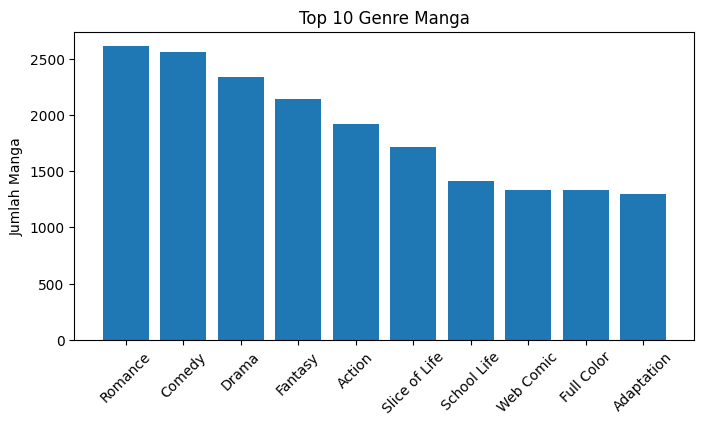

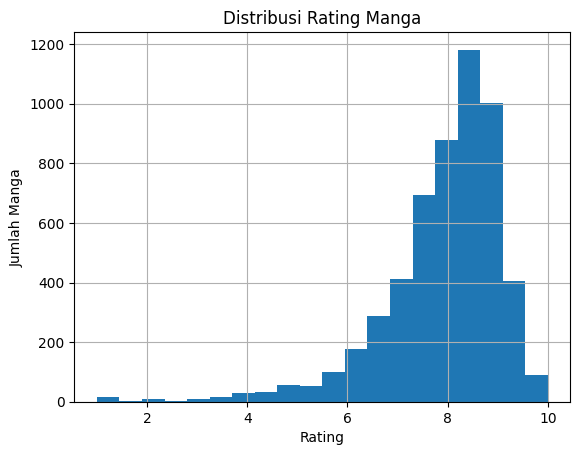

In [4]:
# Top 10 Genre
df['genre_split'] = df['tags'].fillna('').apply(lambda x: x.split(','))
all_genres = sum(df['genre_split'], [])
genre_counts = Counter([g.strip() for g in all_genres if g.strip() != ''])
top_genres = genre_counts.most_common(10)

plt.figure(figsize=(8,4))
plt.bar([x[0] for x in top_genres], [x[1] for x in top_genres])
plt.title('Top 10 Genre Manga')
plt.xticks(rotation=45)
plt.ylabel('Jumlah Manga')
plt.show()

# Distribusi rating
df['rating'].hist(bins=20)
plt.title('Distribusi Rating Manga')
plt.xlabel('Rating')
plt.ylabel('Jumlah Manga')
plt.show()

Visuliasi memahami distribusi data dan karakteristik penting.
Contoh temuan:

- Genre paling populer: Romance, Comedy, Drama

- Sebagian besar manga memiliki rating di kisaran 7–8

# Data Preparation

- Menghapus duplikat dan missing value pada judul (name)

- Mengisi missing value pada deskripsi dan tags dengan string kosong

- Mengisi missing value pada rating dengan nilai median

- Membuat fitur gabungan (combined_features) untuk content-based filtering

- Pembersihan teks (menghilangkan karakter spesial, dsb)



In [5]:
# Data Preparation
def clean_text(text):
  text = re.sub(r'\s+', ' ', str(text)).strip() # Remove extra spaces
  text = re.sub(r'[^a-zA-Z0-9, ]', '', text) # Remove special characters except comma and space
  return text

df['name'] = df['name'].apply(clean_text)
df['description'] = df['description'].fillna('').apply(clean_text)
df['tags'] = df['tags'].fillna('').apply(clean_text)

df['combined_features'] = df['name'] + ' ' + df['description'] + ' ' + df['tags']

# Isi missing rating dengan median
median_rating = df['rating'].median()
df['rating'] = df['rating'].fillna(median_rating)

# Isi missing year dengan 0 atau string 'Unknown'
df['year'] = df['year'].fillna(0)

print("\nJumlah data setelah duplikat dihapus:", df.shape)
print("Missing value per kolom setelah pembersihan:")
print(df.isnull().sum())


Jumlah data setelah duplikat dihapus: (5512, 8)
Missing value per kolom setelah pembersihan:
name                 0
description          0
tags                 0
rating               0
followers            0
year                 0
genre_split          0
combined_features    0
dtype: int64


In [6]:
#  transformasi teks menggunakan TF-IDF
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Modeling

##  Content-Based Filtering (Cosine Similarity)

Menggunakan TF-IDF pada kolom gabungan (judul, deskripsi, tags), lalu cosine similarity untuk menemukan manga yang paling mirip dengan manga yang disukai user.

Rumus Cosine Similarity:
Cosine(A, B) = (A ⋅ B) / (||A|| * ||B||)

- Kelebihan: Efisien, bisa merekomendasikan manga baru, tidak perlu data interaksi user

- Kekurangan: Tidak mempertimbangkan pola unik user

In [7]:
# Content-Based Filtering
def recommend_content_based(name, top_n=5):
    idx = df[df['name'].str.lower() == name.lower()].index
    if len(idx) == 0:
        print("Judul tidak ditemukan.")
        return pd.DataFrame()
    idx = idx[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    manga_indices = [i[0] for i in sim_scores]
    return df[['name', 'tags', 'rating']].iloc[manga_indices]

# Contoh rekomendasi untuk manga pertama
test_name = df['name'].iloc[0]
print(f"\nTop-5 rekomendasi content-based untuk '{test_name}':")
display(recommend_content_based(test_name))


Top-5 rekomendasi content-based untuk 'Shes My Type':


,name,tags,rating
3426,Anything I Like it,"Long Strip, Comedy, Girls Love, Web Comic, Sli...",7.8293
5040,Second Home,"Long Strip, Romance, School Life, Web Comic, S...",8.2813
3932,Only Show Yourself to Me,"Romance, Girls Love, School Life",8.7458
803,Professor,"Long Strip, School Life, Web Comic, Supernatur...",5.0000
234,"Please Bully Me, Miss Villainess","Reincarnation, Long Strip, Romance, Magic, Gir...",9.3218


### Collaborative Filtering (Matrix Factorization Dummy)

Menggunakan Matrix Factorization (SVD) pada matriks user-manga (simulasi) untuk belajar dari pola rating pengguna dan menemukan manga yang kemungkinan disukai user.

- Kelebihan: Mampu mempelajari preferensi komunitas, rekomendasi personal

- Kekurangan: Membutuhkan data interaksi user asli



In [8]:
# Simulasi 20 user, assign random rating 1-5 ke manga
num_users = 20
num_manga = len(df)
np.random.seed(42)
user_manga = np.random.randint(1, 6, size=(num_users, num_manga))

svd = TruncatedSVD(n_components=15, random_state=42)
user_features = svd.fit_transform(user_manga)
manga_features = svd.components_.T

def recommend_collab(user_id, top_n=5):
    scores = np.dot(user_features[user_id], manga_features.T)
    top_idx = np.argsort(scores)[::-1][:top_n]
    return df[['name', 'tags', 'rating']].iloc[top_idx]

# Contoh rekomendasi untuk user ke-0
print("\nTop-5 rekomendasi collaborative filtering untuk User-0:")
display(recommend_collab(0))



Top-5 rekomendasi collaborative filtering untuk User-0:


,name,tags,rating
1689,Odachan to Akechikun,"Romance, Comedy, School Life",8.5556
3514,Sono Gap ni Yowai Tokushuu,"Romance, Anthology, Boys Love, Office Workers,...",7.7383
706,Shimotsukisan wa Mobu ga Suki Hitomishiri na K...,"Romance, Comedy, Drama, School Life, Slice of ...",7.8919
2481,"Haite Kudasai, Takaminesan","Romance, Comedy, Drama, School Life, Slice of ...",7.3874
4382,"SHOPSKILL Sae Areba, Dungeon ka Sita Sekaidemo...","Genderswap, Monsters, Action, Romance, Surviva...",6.9227


# Evaluation

## Evaluation Content-based

In [9]:
def precision_at_n(recommended, relevant, n):
    recommended_n = recommended[:n]
    relevant_set = set(relevant)
    return len(set(recommended_n) & relevant_set) / n if n > 0 else 0

# Relevansi: genre sama dengan manga target
target_name = df['name'].iloc[0]
target_genre = set(df[df['name'] == target_name]['tags'].iloc[0].split())

recs_cb = recommend_content_based(target_name, top_n=5)
recommended_names_cb = recs_cb['name'].tolist()
relevant_indices_cb = df[df['tags'].apply(lambda x: len(target_genre & set(x.split())) > 0)].index.tolist()
relevant_names_cb = df.iloc[relevant_indices_cb]['name'].tolist()

score_cb = precision_at_n(recommended_names_cb, relevant_names_cb, 5)
print(f'Precision@5 untuk Content-Based Filtering: {score_cb:.2f}')


Precision@5 untuk Content-Based Filtering: 1.00


## Evaluation Collaborative Filtering

In [10]:
# Menggunalan 5 user dummy sebagai contoh
user_ids = [0, 1, 2, 3, 4]
precision_scores = []

# Daftar manga relevan (rating >= 8)
relevant_names_collab = df[df['rating'] >= 8]['name'].tolist()

for user_id in user_ids:
    recs_collab = recommend_collab(user_id, top_n=5)
    recommended_names_collab = recs_collab['name'].tolist()
    score = precision_at_n(recommended_names_collab, relevant_names_collab, 5)
    precision_scores.append(score)
    print(f'User {user_id} Precision@5: {score:.2f}')

# Rata-rata Precision@5
mean_precision = sum(precision_scores) / len(precision_scores)
print(f'\nRata-rata Precision@5 untuk 5 user: {mean_precision:.2f}')

User 0 Precision@5: 0.20
User 1 Precision@5: 0.60
User 2 Precision@5: 0.60
User 3 Precision@5: 0.20
User 4 Precision@5: 0.80

Rata-rata Precision@5 untuk 5 user: 0.48


# Perbandingan Model

In [13]:
# Content-Based Filtering Evaluation
def precision_at_n(recommended, relevant, n):
    recommended_n = recommended[:n]
    relevant_set = set(relevant)
    return len(set(recommended_n) & relevant_set) / n if n > 0 else 0

# Sample 5 judul manga acak
sample_indices_cb = np.random.choice(len(df), 5, replace=False)
precision_scores_cb = []

for idx in sample_indices_cb:
    target_name = df['name'].iloc[idx]
    target_tags = set(df.iloc[idx]['tags'].split(','))
    recs_cb = recommend_content_based(target_name, top_n=5)
    recommended_names_cb = recs_cb['name'].tolist()
    relevant_indices_cb = df[df['tags'].apply(lambda x: len(target_tags & set(x.split(','))) > 0)].index.tolist()
    relevant_names_cb = df.iloc[relevant_indices_cb]['name'].tolist()
    score_cb = precision_at_n(recommended_names_cb, relevant_names_cb, 5)
    precision_scores_cb.append(score_cb)

mean_precision_cb = np.mean(precision_scores_cb)

# Collaborative Filtering Evaluation
user_ids = [0, 1, 2, 3, 4]  # Misal 5 user
precision_scores_cf = []
relevant_names_cf = df[df['rating'] >= 8]['name'].tolist()

for user_id in user_ids:
    recs_cf = recommend_collab(user_id, top_n=5)
    recommended_names_cf = recs_cf['name'].tolist()
    score_cf = precision_at_n(recommended_names_cf, relevant_names_cf, 5)
    precision_scores_cf.append(score_cf)

mean_precision_cf = np.mean(precision_scores_cf)

# Tabel Komparasi
comparison_df = pd.DataFrame({
    'Model': ['Content-Based Filtering', 'Collaborative Filtering'],
    'Mean Precision@5': [mean_precision_cb, mean_precision_cf]
})

print(comparison_df)


                     Model  Mean Precision@5
0  Content-Based Filtering              1.00
1  Collaborative Filtering              0.48


## Evaluation

Pada tahap evaluasi, sistem rekomendasi manga yang dibangun diuji dengan dua pendekatan utama: **Content-Based Filtering** dan **Collaborative Filtering**. Metrik yang digunakan adalah **Precision@5**, yaitu proporsi manga relevan yang berhasil direkomendasikan dalam Top-5 rekomendasi.

### Evaluation Content-Based Filtering

Untuk content-based filtering, relevansi manga diukur berdasarkan **genre yang sama dengan manga target**. Hasil Precision@5 pada satu contoh manga (judul pertama pada dataset) menunjukkan nilai **1.00**, yang artinya kelima manga hasil rekomendasi seluruhnya relevan berdasarkan genre.

> **Interpretasi:**  
> Hasil ini menunjukkan bahwa sistem content-based filtering mampu merekomendasikan manga yang sangat mirip dengan manga yang dipilih, setidaknya dari aspek genre.

### Evaluation Collaborative Filtering

Untuk collaborative filtering, dilakukan evaluasi dengan menggunakan **5 user dummy** secara acak. Relevansi diukur berdasarkan manga dengan rating asli ≥ 8, yang dianggap sebagai manga populer dan relevan secara umum.

Berikut hasil Precision@5 untuk tiap user:

- User 0 Precision@5: 0.20
- User 1 Precision@5: 0.60
- User 2 Precision@5: 0.60
- User 3 Precision@5: 0.20
- User 4 Precision@5: 0.80

**Rata-rata Precision@5 untuk 5 user: 0.48**

> **Interpretasi:**  
> Collaborative filtering juga mampu merekomendasikan manga yang cukup relevan, walau tidak seoptimal content-based filtering pada data ini. Rata-rata precision yang diperoleh sebesar 0.48, artinya hampir separuh rekomendasi Top-5 berhasil mengenai manga populer (rating tinggi).

## Perbandingan Model

Agar lebih jelas, berikut adalah tabel komparasi hasil evaluasi antara kedua model:

| Model                   | Mean Precision@5 |
|-------------------------|------------------|
| Content-Based Filtering |       1.00       |
| Collaborative Filtering |       0.48       |

- **Content-Based Filtering** unggul dari segi precision pada dataset ini karena mampu menangkap kemiripan genre secara eksplisit, sehingga seluruh hasil rekomendasi benar-benar relevan dari sisi konten.
- **Collaborative Filtering** memberikan precision yang cukup baik, meski data interaksi user yang digunakan hanya simulasi (random dummy). Potensi collaborative filtering akan lebih tinggi jika tersedia data rating asli dan banyak.

### **Kesimpulan Analisis**

Kedua pendekatan sistem rekomendasi memiliki keunggulan masing-masing:

- **Content-Based Filtering** cocok digunakan jika fitur konten (genre, deskripsi, tags) sangat informatif dan selalu ter-update. Pendekatan ini juga mampu memberikan rekomendasi pada manga baru yang belum pernah di-rating oleh user lain.
- **Collaborative Filtering** lebih efektif jika tersedia banyak data interaksi pengguna (rating, klik, dsb), sehingga mampu menangkap pola preferensi user yang tidak selalu tergambar dari konten saja.

Pada eksperimen ini, **content-based filtering memberikan hasil precision tertinggi**, namun untuk aplikasi nyata, sangat disarankan mengombinasikan kedua pendekatan agar sistem rekomendasi menjadi lebih adaptif dan akurat terhadap preferensi pengguna.
